In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
train_dir = '/kaggle/input/cats-and-dogs-image-classification/train'
test_dir = '/kaggle/input/cats-and-dogs-image-classification/test'

In [4]:
train_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
test_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transformation)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transformation)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 557
    Root location: /kaggle/input/cats-and-dogs-image-classification/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [9]:
test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 140
    Root location: /kaggle/input/cats-and-dogs-image-classification/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

/tmp/ipykernel_1780/2786887181.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3697.)
  plt.imshow(image[0].T)


tensor(0)


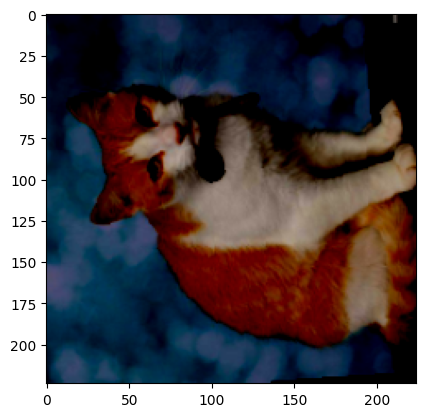

In [10]:
import matplotlib.pyplot as plt

for image, label in test_loader:
    plt.imshow(image[0].T)
    print(label[0])
    break

In [11]:
train_dataset.classes

['cats', 'dogs']

In [12]:
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of training images: 557
Number of test images: 140


In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(54 * 54 * 64, 256)
        self.fc2 = nn.Linear(256, 2)
        
        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        
        x = x.view(-1, 54 * 54 * 64)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [15]:
model = SimpleCNN()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
model = model.to(device)

In [18]:
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [33]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fun(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * (correct / total)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

Epoch [1/10], Loss: 0.3883, Accuracy: 86.00%
Epoch [2/10], Loss: 0.5609, Accuracy: 85.10%
Epoch [3/10], Loss: 0.4908, Accuracy: 83.66%
Epoch [4/10], Loss: 0.5063, Accuracy: 82.59%
Epoch [5/10], Loss: 0.4130, Accuracy: 84.74%
Epoch [6/10], Loss: 0.4550, Accuracy: 85.28%
Epoch [7/10], Loss: 0.4578, Accuracy: 83.30%
Epoch [8/10], Loss: 0.4193, Accuracy: 83.48%
Epoch [9/10], Loss: 0.3273, Accuracy: 84.74%
Epoch [10/10], Loss: 0.3952, Accuracy: 86.89%


In [34]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * (correct / total)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 63.57%


In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Function to unnormalize and show the image
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

In [23]:
# Function to get class name from index
def get_class_name(idx, dataset):
    return dataset.classes[idx]

In [24]:
# Function to display images with predictions
def visualize_predictions(model, test_loader, dataset, num_images=4):
    model.eval()
    
    images, labels = next(iter(test_loader))
    images, labels = images[:num_images], labels[:num_images]
    images, labels = images.to(device), labels.to(device)

    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    
    for i in range(num_images):
        img = images[i].cpu()
        actual_label = get_class_name(labels[i].item(), dataset)
        predicted_label = get_class_name(predicted[i].item(), dataset)
        
        title = f'Actual: {actual_label}, Predicted: {predicted_label}'
        imshow(img, title)

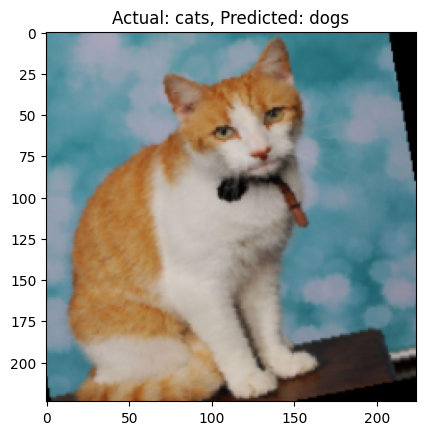

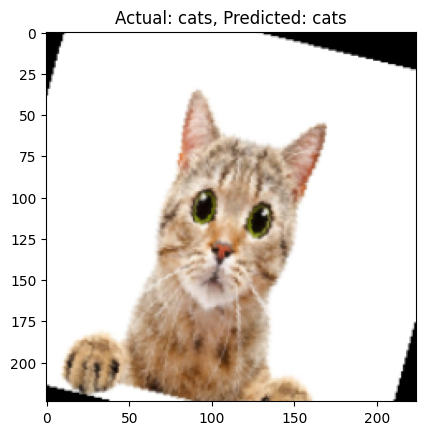

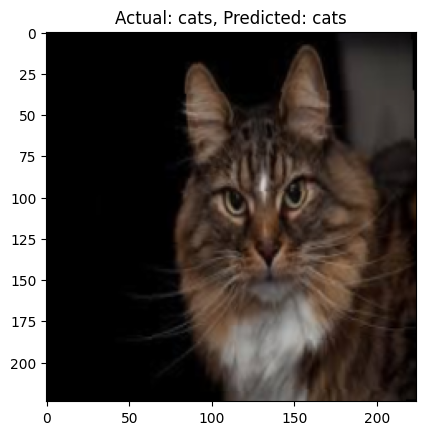

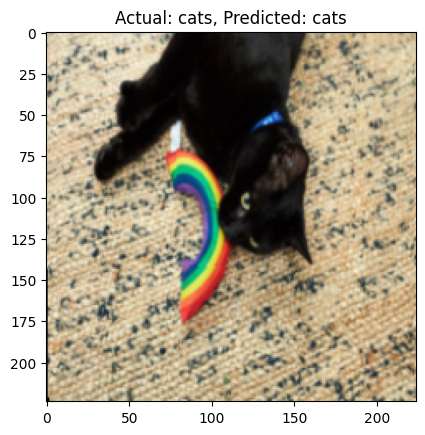

In [35]:
visualize_predictions(model, test_loader, test_dataset, num_images=4)